# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


In [746]:
# Parameters
m = 3
A = 0.001#0.05#0.049375#0.07#0.05#0.1124921875#0.125
run = 1

1

In [747]:
res=m;
N=2.0^m*500/5.0
Xf=1.0;

dx=Xf/N;
dt=round(dx,digits=10);
Nt=2.0^m*500.0/5.0
Tf=Nt*dt; #final time
print(Tf)

1.0

In [748]:
print(N)

800.0

In [749]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)

dx =0.00125
dt =0.00125
dx/dt =1.0


In [750]:
global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"
#global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA"

# Grid

In [751]:
include("./ScalarField.jl");

In [752]:
ori=0.0;
initX1 = nothing
N=int(N)
initX1=range(ori, stop=Xf, step=dx);

initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)
println("the time step is ", dt)

step size is  0.00125
the time step is 0.00125


# Initial data of m β Ψ and Ψ,x

In [753]:
if m==1
    initX1=chebishev(int((L-6)))
    L1=L;
elseif m==2
    initX1=doublegrid(chebishev(int((L1-6))))
else
    initX1=doublegrid(doublegrid(chebishev(int((L1-6)))))
end
initX=collect(initX)
initX[4:L-3]=initX1;

In [754]:
using Dierckx

####

initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initderpsi=zeros(L);

state_array=[initm initbeta initpsi initderpsi initX];

#PSI
r0=0.01#0.7#0.3
sigma=0.3
initpsi[4:L-3] = init_gaussian(initX1,r0,sigma,A)

state_array[:,3] = initpsi
state_array = ghost(state_array)

#PSI,X FROM PSI
initderpsi[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)
state_array[:,4] = initderpsi
state_array=ghost(state_array)

####

derpsi_func = Spline1D(initX[4:L-3], initderpsi[4:L-3],  k=4);

In [755]:
"""aux=doublegrid(initX1)
derpsi_func(aux);

using Plots
plot(aux, derpsi_func(aux).-init_gaussian_der(aux,r0,sigma,A), xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, ylim=[0, 10^(-13)])"""

"aux=doublegrid(initX1)\nderpsi_func(aux);\n\nusing Plots\nplot(aux, derpsi_func(aux).-init_gaussian_der(aux,r0,sigma,A), xaxis=\"x\",title=\"Initial Data\", labels=[\"m\" \"beta\" \"psi\" \"psi,x\"])#, ylim=[0, 10^(-13)])"

In [756]:
"""x1=aux
y1=derpsi_func(aux).-init_gaussian_der(aux,r0,sigma,A)"""

"x1=aux\ny1=derpsi_func(aux).-init_gaussian_der(aux,r0,sigma,A)"

In [757]:
"""x2=aux
y2=derpsi_func(aux).-init_gaussian_der(aux,r0,sigma,A)"""

"x2=aux\ny2=derpsi_func(aux).-init_gaussian_der(aux,r0,sigma,A)"

In [758]:
"""

double_resolution=y2
basis_resolution=y1
xs = ( x1, x2 )
ys = ( basis_resolution, double_resolution*16*4 )
p = plot()
map(x->plot!(x[1],x[2],xaxis="x",title="Interpolation error", legend=false), zip(xs, ys))
display(p)
     
"""

"\ndouble_resolution=y2\nbasis_resolution=y1\nxs = ( x1, x2 )\nys = ( basis_resolution, double_resolution*16*4 )\np = plot()\nmap(x->plot!(x[1],x[2],xaxis=\"x\",title=\"Interpolation error\", legend=false), zip(xs, ys))\ndisplay(p)\n     \n"

In [759]:
y0=[0 0 0]
state_array[4:L-3,1:3] = n_rk4wrapper(RHS,y0,initX[4:L-3],0,derpsi_func,state_array[:,:])

"""y0=[0]
state_array[4:L-3,3] = n_rk4wrapper(psi_RHS,y0,initX[4:L-3],0,derpsi_func,state_array[4:L-3,:])
"""
state_array = ghost(state_array);

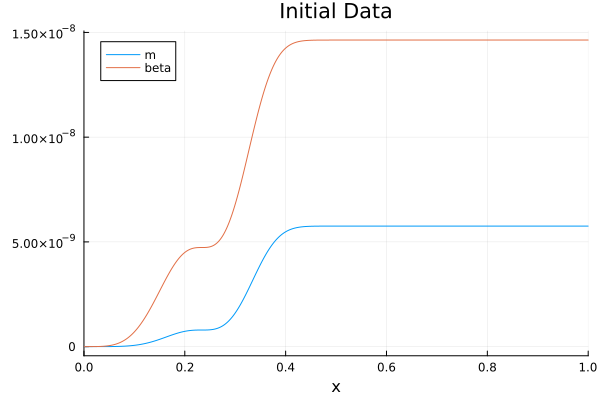

In [760]:
using Plots #showing initial data and the initial status of the horizon finder
plot(initX[4:L-3], state_array[4:L-3,1:2], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"],xlim=[0,1])

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [761]:
using CSV, Tables
#CSV.write(dir*"/time_step0.csv", Tables.table(transpose(Matrix(state_array))), writeheader=false)
CSV.write(dir*"/res$res/time_step0.csv", Tables.table(state_array), writeheader=false)

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res3/time_step0.csv"

In [450]:
time=0.0
criticality=0.0
explode=0.0
evol_stats = [criticality A sigma r0 time explode run]
monitor_ratio = zeros(L)
CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "time", "explode", "run"])

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv"

In [451]:
ginit=dt_scale(initX,state_array[:,1],state_array[:,2],dx)
println(update_dt(initX,state_array[:,1],state_array[:,2],dx,ginit)/dt)

1.0


 ## Time evolution

fixed grid

In [433]:
finaltime=1#0.9#0.8#0.04*5*4#length(T)-1
evol_stats, T_interp = timeevolution(state_array,finaltime,dir*"/res$res",run);
CSV.write(dir*"/timearray$res.csv", Tables.table(T_interp), writeheader=false);
#CSV.write(dir*"/parameters.csv", Tables.table(evol_stats), writeheader=false);

iteration 1 dt is 0.00125, time of iteration is 0.00125
iteration 2 dt is 0.00125, time of iteration is 0.0025
iteration 3 dt is 0.00125, time of iteration is 0.00375
iteration 4 dt is 0.00125, time of iteration is 0.005
iteration 5 dt is 0.00125, time of iteration is 0.00625
iteration 6 dt is 0.00125, time of iteration is 0.0075
iteration 7 dt is 0.00125, time of iteration is 0.00875
iteration 8 dt is 0.00125, time of iteration is 0.01
iteration 9 dt is 0.00125, time of iteration is 0.01125
iteration 10 dt is 0.00125, time of iteration is 0.0125
iteration 11 dt is 0.00125, time of iteration is 0.01375
iteration 12 dt is 0.00125, time of iteration is 0.015
iteration 13 dt is 0.00125, time of iteration is 0.01625
iteration 14 dt is 0.00125, time of iteration is 0.0175
iteration 15 dt is 0.00125, time of iteration is 0.01875
iteration 16 dt is 0.00125, time of iteration is 0.02
iteration 17 dt is 0.00125, time of iteration is 0.02125
iteration 18 dt is 0.00125, time of iteration is 0.022

iteration 147 dt is 0.00125, time of iteration is 0.18375
iteration 148 dt is 0.00125, time of iteration is 0.185
iteration 149 dt is 0.00125, time of iteration is 0.18625
iteration 150 dt is 0.00125, time of iteration is 0.1875
iteration 151 dt is 0.00125, time of iteration is 0.18875
iteration 152 dt is 0.00125, time of iteration is 0.19
iteration 153 dt is 0.00125, time of iteration is 0.19125
iteration 154 dt is 0.00125, time of iteration is 0.1925
iteration 155 dt is 0.00125, time of iteration is 0.19375
iteration 156 dt is 0.00125, time of iteration is 0.195
iteration 157 dt is 0.00125, time of iteration is 0.19625
iteration 158 dt is 0.00125, time of iteration is 0.1975
iteration 159 dt is 0.00125, time of iteration is 0.19875
iteration 160 dt is 0.00125, time of iteration is 0.2
iteration 161 dt is 0.00125, time of iteration is 0.20125
iteration 162 dt is 0.00125, time of iteration is 0.2025
iteration 163 dt is 0.00125, time of iteration is 0.20375
iteration 164 dt is 0.00125, 

iteration 292 dt is 0.00125, time of iteration is 0.365
iteration 293 dt is 0.00125, time of iteration is 0.36625
iteration 294 dt is 0.00125, time of iteration is 0.3675
iteration 295 dt is 0.00125, time of iteration is 0.36875
iteration 296 dt is 0.00125, time of iteration is 0.37
iteration 297 dt is 0.00125, time of iteration is 0.37125
iteration 298 dt is 0.00125, time of iteration is 0.3725
iteration 299 dt is 0.00125, time of iteration is 0.37375
iteration 300 dt is 0.00125, time of iteration is 0.375
iteration 301 dt is 0.00125, time of iteration is 0.37625
iteration 302 dt is 0.00125, time of iteration is 0.3775
iteration 303 dt is 0.00125, time of iteration is 0.37875
iteration 304 dt is 0.00125, time of iteration is 0.38
iteration 305 dt is 0.00125, time of iteration is 0.38125
iteration 306 dt is 0.00125, time of iteration is 0.3825
iteration 307 dt is 0.00125, time of iteration is 0.38375
iteration 308 dt is 0.00125, time of iteration is 0.385
iteration 309 dt is 0.00125, t

iteration 437 dt is 0.00125, time of iteration is 0.54625
iteration 438 dt is 0.00125, time of iteration is 0.5475
iteration 439 dt is 0.00125, time of iteration is 0.54875
iteration 440 dt is 0.00125, time of iteration is 0.55
iteration 441 dt is 0.00125, time of iteration is 0.55125
iteration 442 dt is 0.00125, time of iteration is 0.5525
iteration 443 dt is 0.00125, time of iteration is 0.55375
iteration 444 dt is 0.00125, time of iteration is 0.555
iteration 445 dt is 0.00125, time of iteration is 0.55625
iteration 446 dt is 0.00125, time of iteration is 0.5575
iteration 447 dt is 0.00125, time of iteration is 0.55875
iteration 448 dt is 0.00125, time of iteration is 0.56
iteration 449 dt is 0.00125, time of iteration is 0.56125
iteration 450 dt is 0.00125, time of iteration is 0.5625
iteration 451 dt is 0.00125, time of iteration is 0.56375
iteration 452 dt is 0.00125, time of iteration is 0.565
iteration 453 dt is 0.00125, time of iteration is 0.56625
iteration 454 dt is 0.00125,

iteration 582 dt is 0.00125, time of iteration is 0.7275
iteration 583 dt is 0.00125, time of iteration is 0.72875
iteration 584 dt is 0.00125, time of iteration is 0.73
iteration 585 dt is 0.00125, time of iteration is 0.73125
iteration 586 dt is 0.00125, time of iteration is 0.7325
iteration 587 dt is 0.00125, time of iteration is 0.73375
iteration 588 dt is 0.00125, time of iteration is 0.735
iteration 589 dt is 0.00125, time of iteration is 0.73625
iteration 590 dt is 0.00125, time of iteration is 0.7375
iteration 591 dt is 0.00125, time of iteration is 0.73875
iteration 592 dt is 0.00125, time of iteration is 0.74
iteration 593 dt is 0.00125, time of iteration is 0.74125
iteration 594 dt is 0.00125, time of iteration is 0.7425
iteration 595 dt is 0.00125, time of iteration is 0.74375
iteration 596 dt is 0.00125, time of iteration is 0.745
iteration 597 dt is 0.00125, time of iteration is 0.74625
iteration 598 dt is 0.00125, time of iteration is 0.7475
iteration 599 dt is 0.00125, 

iteration 727 dt is 0.00125, time of iteration is 0.90875
iteration 728 dt is 0.00125, time of iteration is 0.91
iteration 729 dt is 0.00125, time of iteration is 0.91125
iteration 730 dt is 0.00125, time of iteration is 0.9125
iteration 731 dt is 0.00125, time of iteration is 0.91375
iteration 732 dt is 0.00125, time of iteration is 0.915
iteration 733 dt is 0.00125, time of iteration is 0.91625
iteration 734 dt is 0.00125, time of iteration is 0.9175
iteration 735 dt is 0.00125, time of iteration is 0.91875
iteration 736 dt is 0.00125, time of iteration is 0.92
iteration 737 dt is 0.00125, time of iteration is 0.92125
iteration 738 dt is 0.00125, time of iteration is 0.9225
iteration 739 dt is 0.00125, time of iteration is 0.92375
iteration 740 dt is 0.00125, time of iteration is 0.925
iteration 741 dt is 0.00125, time of iteration is 0.92625
iteration 742 dt is 0.00125, time of iteration is 0.9275
iteration 743 dt is 0.00125, time of iteration is 0.92875
iteration 744 dt is 0.00125,

 ## Movie of the evolution

[ Info: Saved animation to /home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif


Plots.AnimatedGif("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif")
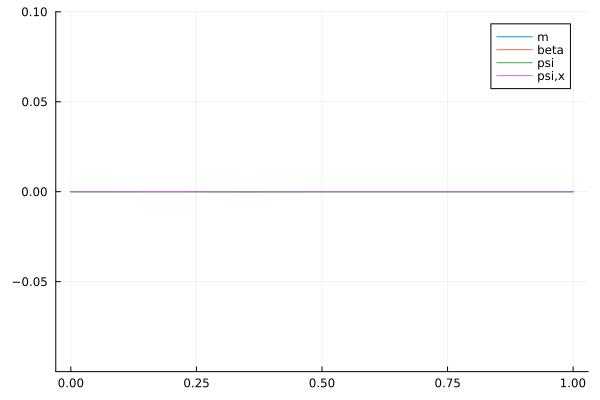

In [301]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 0:1:2
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
        plot5=functions3.Column5[4:L-3];
    
    plot!(initX1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"], ylim=[-0.1, 0.1])#, xlim=[0, 0.1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 20)

In [432]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 10:10:290#length(T)-1
    
    IJulia.clear_output(true)
    
    functions3=DataFrame(CSV.File(dir*"/res$res/monitor_ratio$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
    
    plot!(initX1, [plot1], labels=["monitor ratio"], ylim=[0, 1])# |> display 
    #plot!(initX[4:L-3], [plot1], labels=["m" "beta" "psi" "psi,x"],ylim=[-1,1])#, xlim=[0, 0.1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 5)

LoadError: ArgumentError: "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res2/monitor_ratio10.csv" is not a valid file or doesn't exist

In [51]:
epsilon(dt,dx)

0.015625